In [185]:
%run analyses/imports.py

### 파라미터 특성 분석
- 제안 방법에 사용된 하이퍼파라미터와 정확도 간 상관관계 분석
- 개별 파라미터 박스 플롯

In [186]:
target_dir = 'msl'
src_dir_path = f'{your_root_dir}/TSB-AD/results/{target_dir}'

In [187]:
keywords_to_include = [str(k) for k in list(range(478, 578))]
keywords_to_exclude = [
    '999', '998', '997', 'encoding', 'rep-', 'snntorch', 'wandb'
]

In [188]:
path_loader = PathLoader(src_dir_path, k2in=keywords_to_include, k2ex=keywords_to_exclude)

In [189]:
file_paths = path_loader.get_file_paths()

In [190]:
'''
파라미터 파싱
'''
def parse_params(file_name):
    params = file_name.split('.')[0].split('_')[-1].split('-')
    param_names = [p[:-1] for p in params]  # 'ns8'인 경우 'ns'로 파싱
    # param_names 중에 같은 것이 있다면 그 뒤에 숫자를 붙임
    seen = {}
    for i, name in enumerate(param_names):
        if name in seen:
            seen[name] += 1
            param_names[i] = f"{name}{seen[name]}"
        else:
            seen[name] = 1
    values = [p[-1] for p in params] # 'ns8'인 경우 8이 파싱
    return param_names, values

In [191]:
params_dict = {}
for idx, file_path in enumerate(file_paths):
    df = pd.read_csv(file_path)
    mean_vus_pr = df['VUS-PR'].mean()
    file_name = os.path.basename(file_path)
    param_names, values = parse_params(file_name)
    params_dict[file_name] = [mean_vus_pr] + values

param_df = pd.DataFrame.from_dict(params_dict, orient='index', columns=['VUS-PR', *param_names])
# 첫 번째 열 제외한 모든 열의 dtype을 categorical로 변환
for col in param_df.columns[1:]:
    param_df[col] = param_df[col].astype('category')

    if col == 'ns2':
        renamed_col = 'num_clusters'
    elif col == 'ns':
        renamed_col = 'num_components'
    elif col == 'kl':
        renamed_col = 'kernel'

    # 열 이름 변경
    param_df.rename(columns={col: renamed_col}, inplace=True)

    if col == 'ns2':
        param_df['num_clusters'] = param_df['num_clusters'].replace({
            '1': '16',
            '3': '32'
        })
        # 모든 값을 int로 변환
        param_df['num_clusters'] = param_df['num_clusters'].astype(int)
    elif col == 'ns':
        param_df['num_components'] = param_df['num_components'].replace({
            '1': '16',
            '3': '32'
        })
        # 모든 값을 int로 변환
        param_df['num_components'] = param_df['num_components'].astype(int)
    elif col == 'kl':
        param_df['kernel'] = param_df['kernel'].replace({
            'l': 'linear',
            'p': 'polynomial',
            's': 'sigmoid',
            'r': 'rbf'
        })

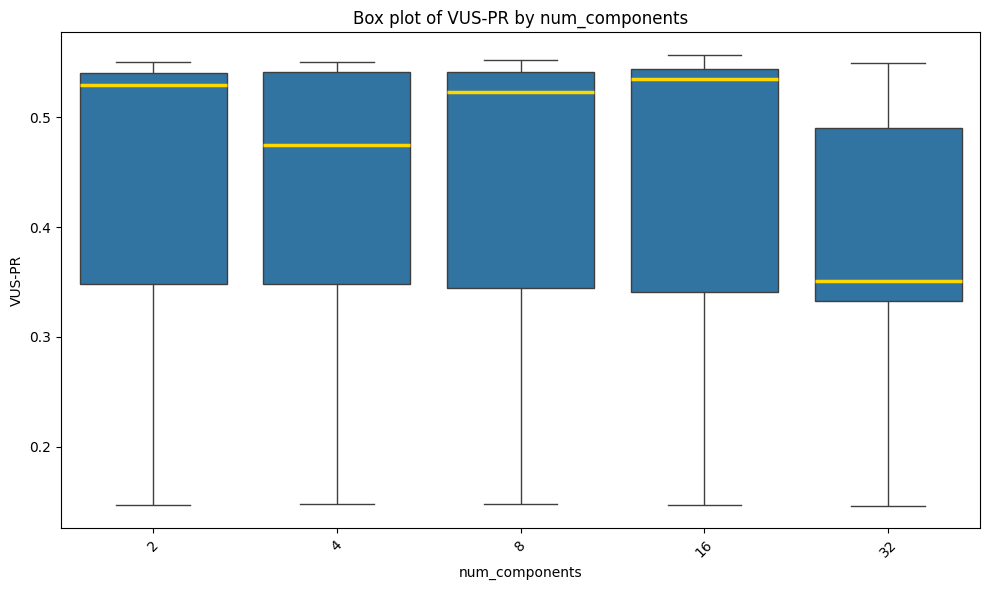

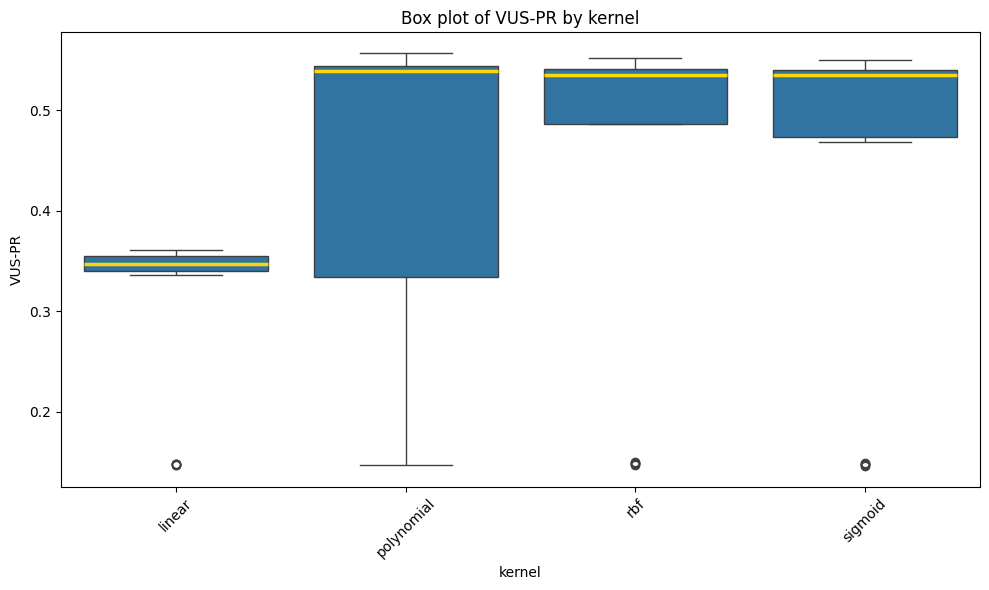

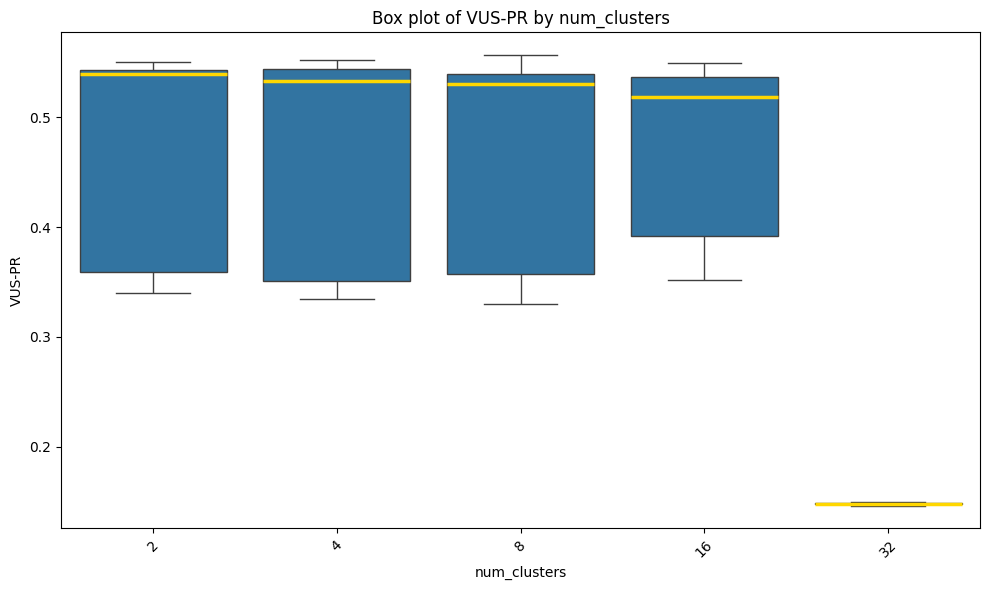

In [196]:
'''
개별 파라미터 박스 플롯
'''
for idx, param in enumerate(param_names):
    # param 이름 변경
    param = param.replace('ns2', 'num_clusters').replace('ns', 'num_components').replace('kl', 'kernel')

    plt.figure(figsize=(10, 6))
    sns.boxplot(
        x=param_df[param],
        y=param_df['VUS-PR'],
        medianprops={'color': 'gold', 'linewidth': 2.5}  # ✅ median 강조
    )
    plt.title(f'Box plot of VUS-PR by {param}')
    plt.xlabel(param)
    plt.ylabel('VUS-PR')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()